# Aligning forecasts and observations

1. Read some Niño 3.4 forecasts and observations from the IRI DL.
2. Given them time coordinates that xarray/pandas understands (not ideal)
3. Add a "valid_time" variable to the forecast dataset (also not idea)
4. Automagically align forecasts and obervations

In [1]:
import numpy as np
import xarray as xr
import pandas as pd

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
nmme_url = 'https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/'
n34_url = 'Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES%5BX/Y%5Daverage/'

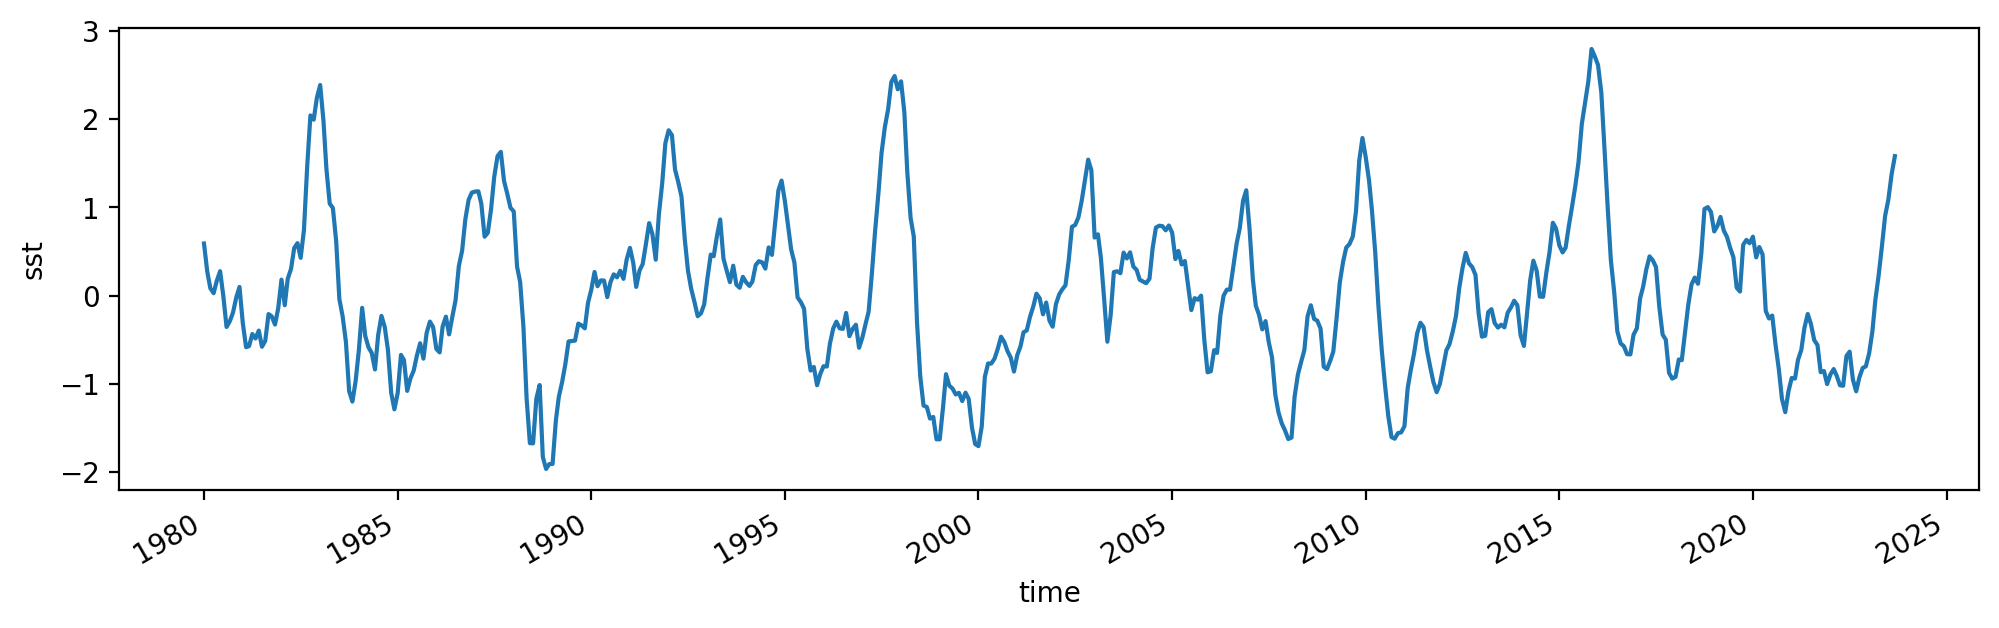

In [3]:
#Observations 
# Construct the url pointing to the data
dl_loc = 'SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/'
time_str = 'T/(Jan%201980)/last/RANGE/'
obs_url = 'https://iridl.ldeo.columbia.edu/' + dl_loc + time_str + n34_url + 'zlev/removeGRID/dods'
ds_obs = xr.open_dataset(obs_url, decode_times=False)

# replace DL time index with a pandas time index
N = len(ds_obs.T)
ds_obs['T'] = pd.date_range(start='1/1/1980', periods=N, freq='MS')
ds_obs = ds_obs.rename({'T': 'time'})
obsa = ds_obs.sst.groupby('time.month') - ds_obs.sst.groupby('time.month').mean('time')
obsa.plot(figsize=(12, 3))
plt.show()

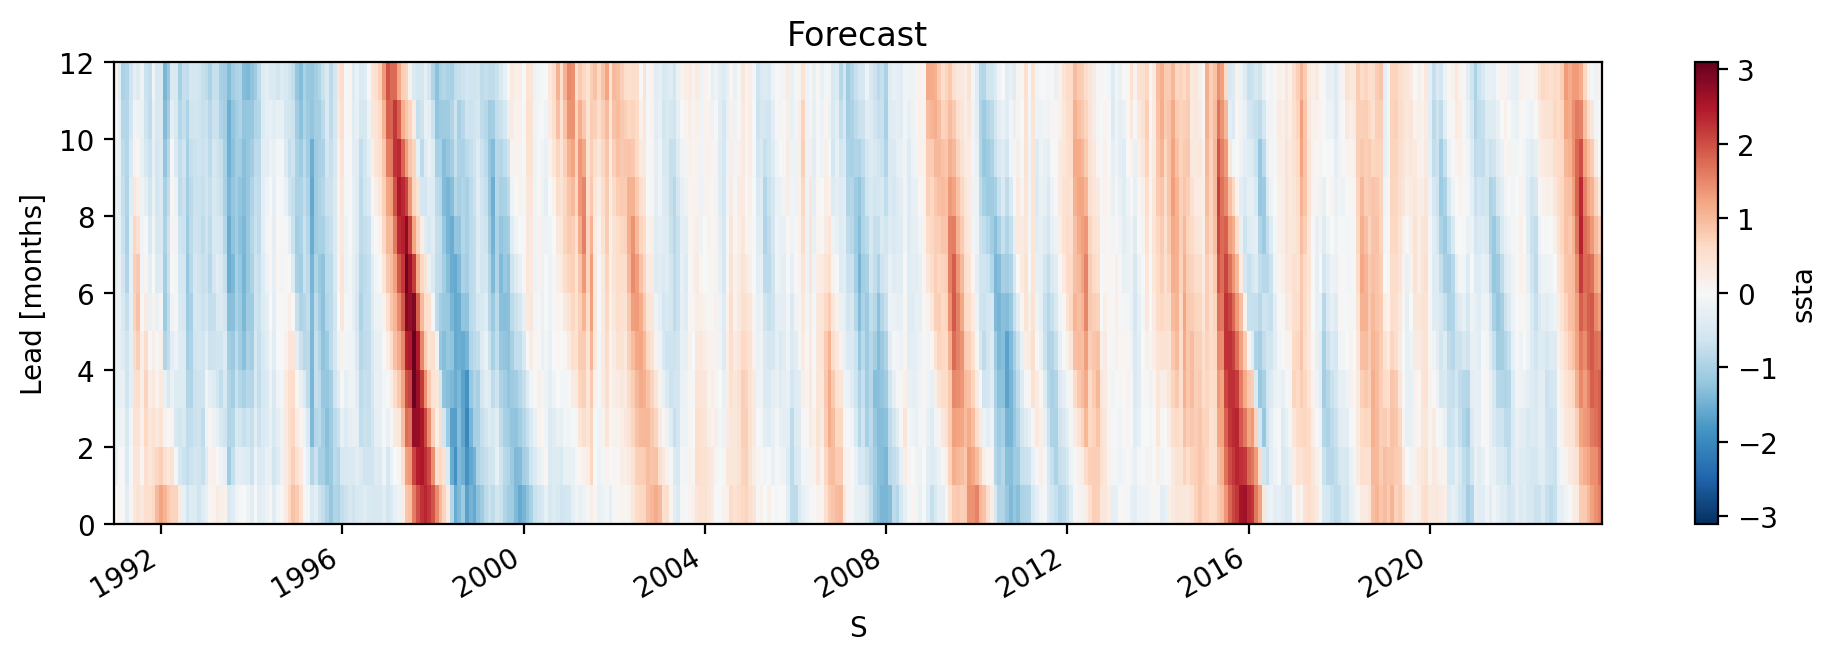

In [4]:
#GFDL-SPEAR
model = 'GFDL-SPEAR'
h_url = nmme_url + '.GFDL-SPEAR/.HINDCAST/.MONTHLY/.sst/' + n34_url + 'dods'
f_url = nmme_url + '.GFDL-SPEAR/.FORECAST/.MONTHLY/.sst/S/(Jan%202021)/last/RANGE/' + n34_url + 'dods'
h_ds = xr.open_dataset(h_url, decode_times=False)
f_ds = xr.open_dataset(f_url, decode_times=False)
ds = xr.concat([h_ds, f_ds], dim='S')

# replace DL time index with a pandas time index
N = len(ds.S)
ds['S'] = pd.date_range(start='1/1/1991', periods=N, freq='MS')

ds['ssta'] = ds.sst.groupby('S.month') - ds.sst.groupby('S.month').mean('S')
ds.ssta.mean('M').plot(x='S', figsize=(12, 3))
plt.title('Forecast')
plt.show()

In [5]:
# add a valid time to the forecast dataset
valid_time = np.empty((len(ds.S), len(ds.L)), dtype='datetime64[ns]')
for lead in range(len(ds.L)):
    valid_time[:, lead] = [(ds.S.values[ii] + pd.DateOffset(months=lead)) for ii in range(len(ds.S))]

ds['valid_time'] = (('S', 'L'), valid_time)

If your observations and forecast have a valid_time and good time grids, you can start here.

In [6]:
# add extre time to the obs (e.g., the future!)
extra_time = np.unique(ds.valid_time)
obsa = obsa.reindex({'time': extra_time})

# this is where the magic happens
ds['obsa'] = (('S', 'L'), obsa.sel(time=ds.valid_time).data)
ds

<xarray.Dataset>
Dimensions:     (M: 30, L: 12, S: 394)
Coordinates:
  * M           (M) float32 1.0 2.0 3.0 4.0 5.0 6.0 ... 26.0 27.0 28.0 29.0 30.0
  * L           (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * S           (S) datetime64[ns] 1991-01-01 1991-02-01 ... 2023-10-01
    month       (S) int64 1 2 3 4 5 6 7 8 9 10 11 12 ... 12 1 2 3 4 5 6 7 8 9 10
Data variables:
    sst         (S, L, M) float64 26.33 26.46 26.43 26.42 ... 26.04 26.03 26.92
    ssta        (S, L, M) float64 -0.08377 0.05979 0.02359 ... -0.01589 -0.1912
    valid_time  (S, L) datetime64[ns] 1991-01-01 1991-02-01 ... 2024-09-01
    obsa        (S, L) float64 0.5411 0.3707 0.09871 0.2839 ... nan nan nan nan
Attributes:
    Conventions:  IRIDL

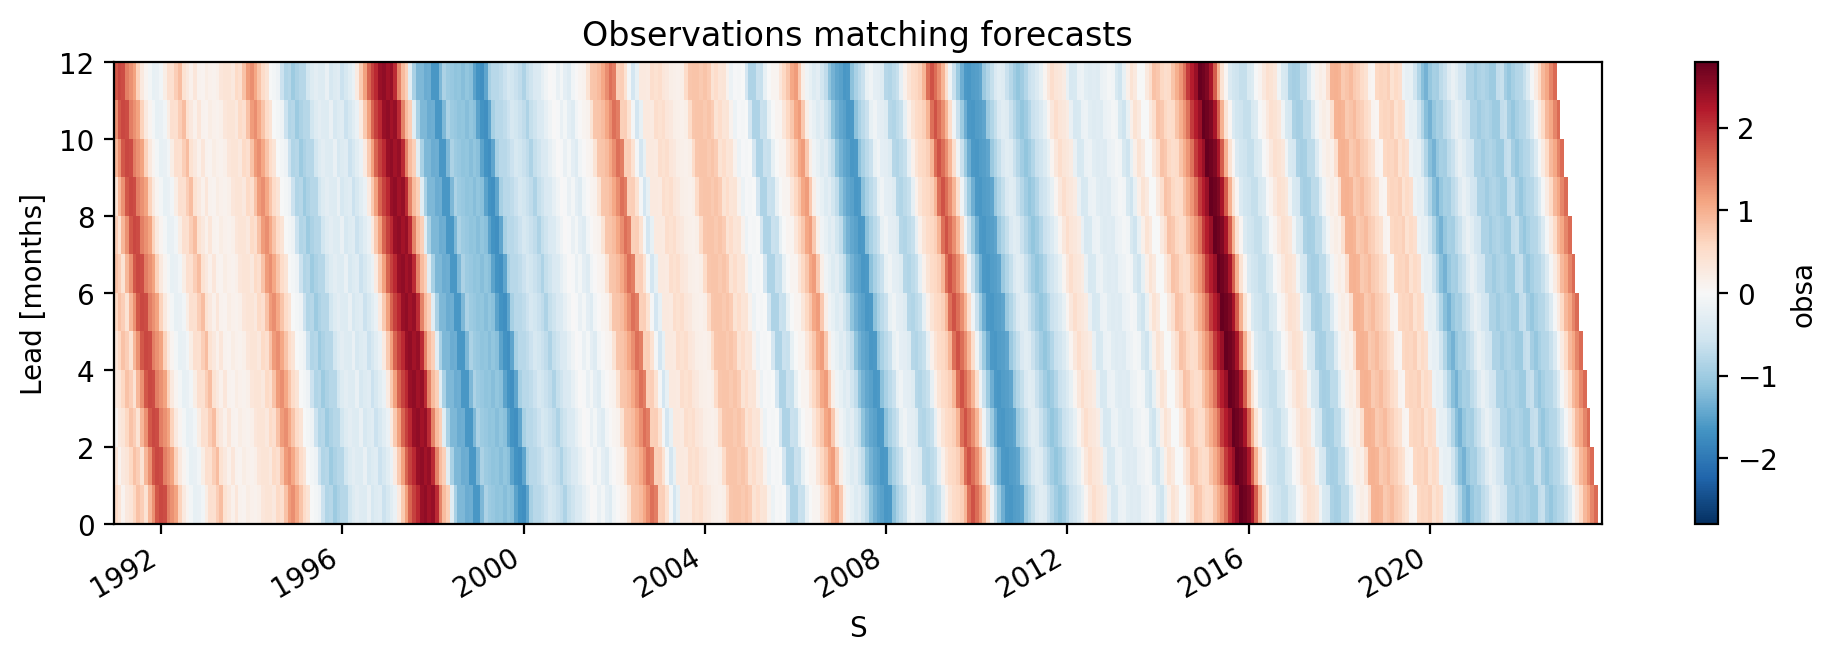

In [7]:
ds.obsa.plot(x='S', figsize=(12, 3))
plt.title('Observations matching forecasts')
plt.show()

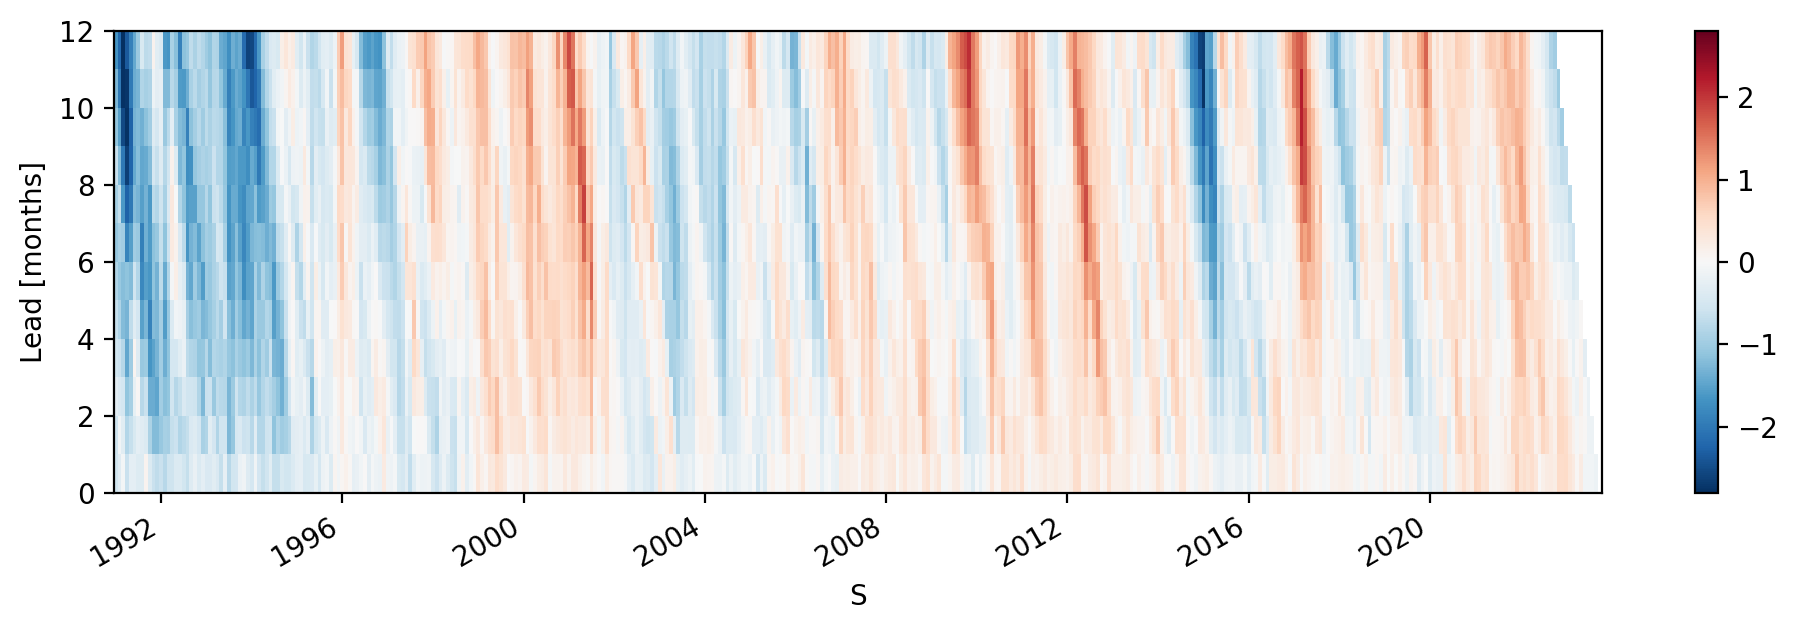

In [8]:
error = ds.ssta.mean('M') - ds.obsa
error.plot(x='S', figsize=(12, 3))
plt.show()

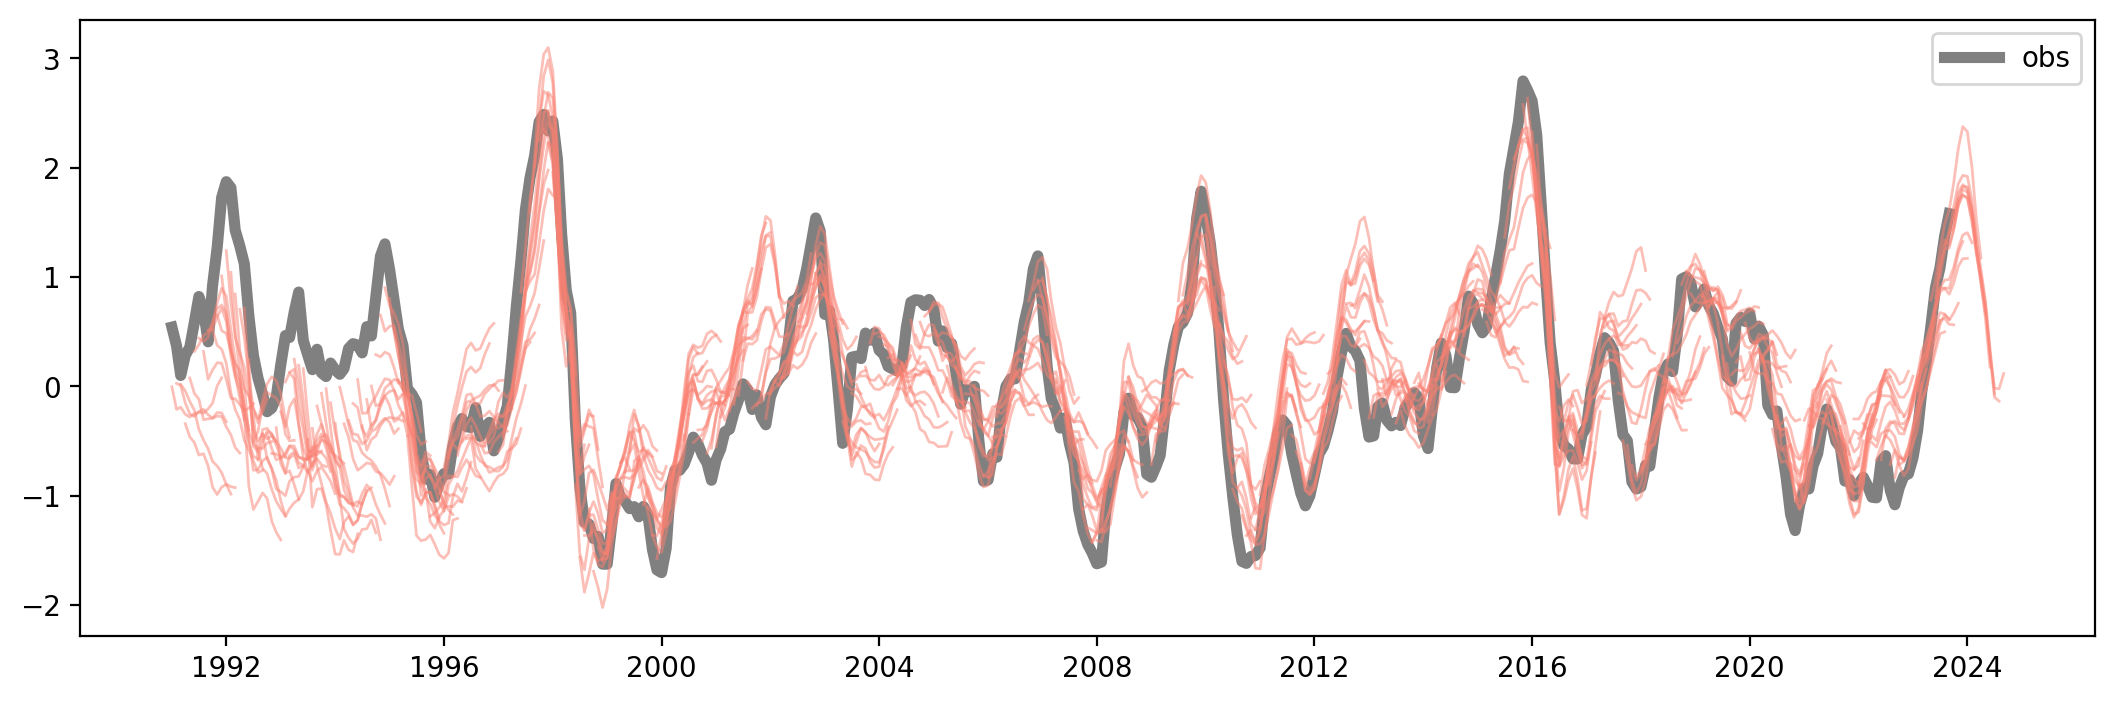

In [9]:
fig, ax = plt.subplots(figsize=(13, 4))
ax.plot(ds.valid_time[:, 0], ds.obsa[:, 0], color='gray', lw=4, label='obs')
ax.plot(ds.valid_time.T, ds.ssta.mean('M').T, 'salmon', lw=1, alpha=0.5)
plt.legend()
plt.show()

# Make a dataset with target and lead dimensions

In [10]:
ds_TL = xr.concat([ds.sel(L=l).swap_dims({"S":"valid_time"}) for l in ds.L],"L")

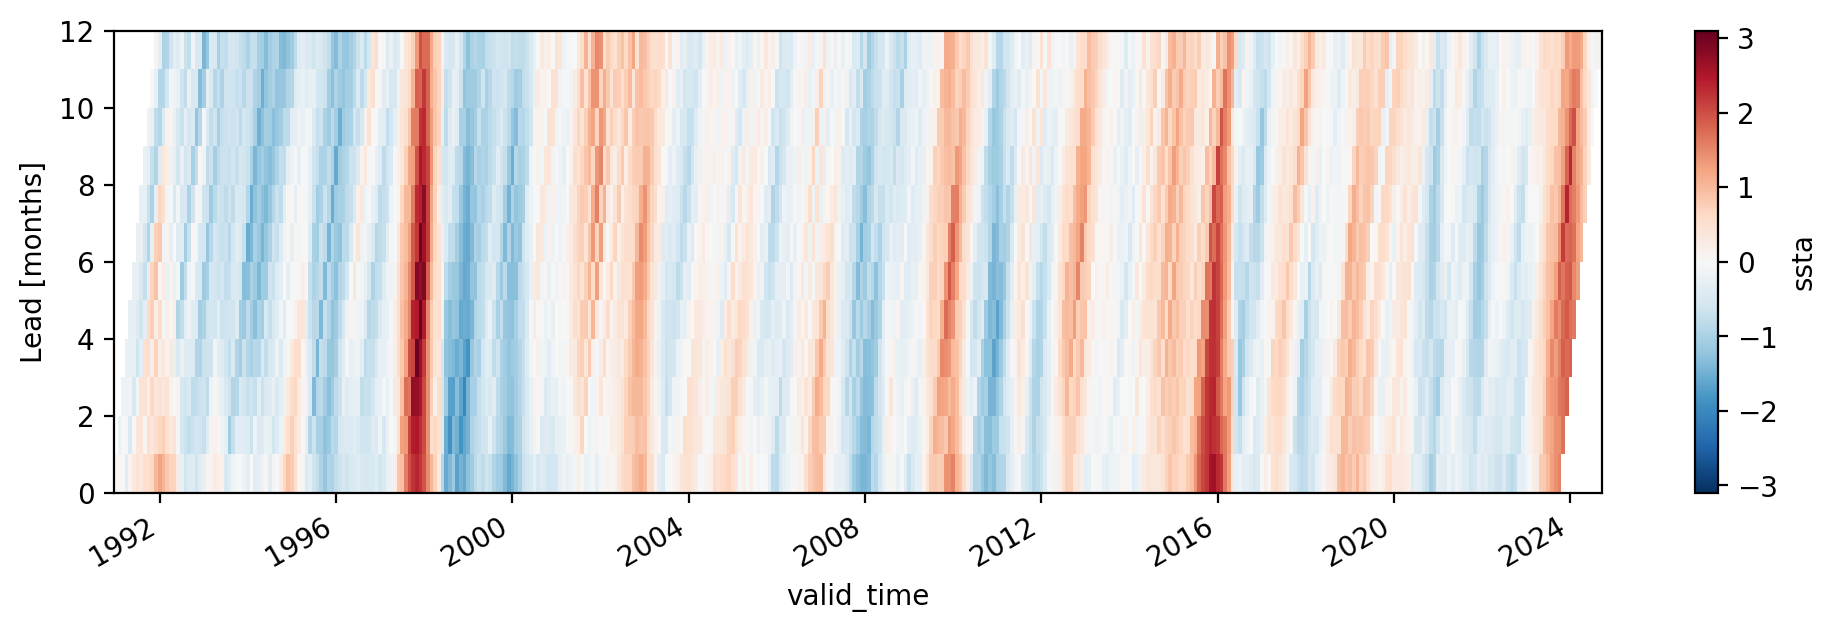

In [11]:
ds_TL.ssta.mean('M').plot(figsize=(12, 3));

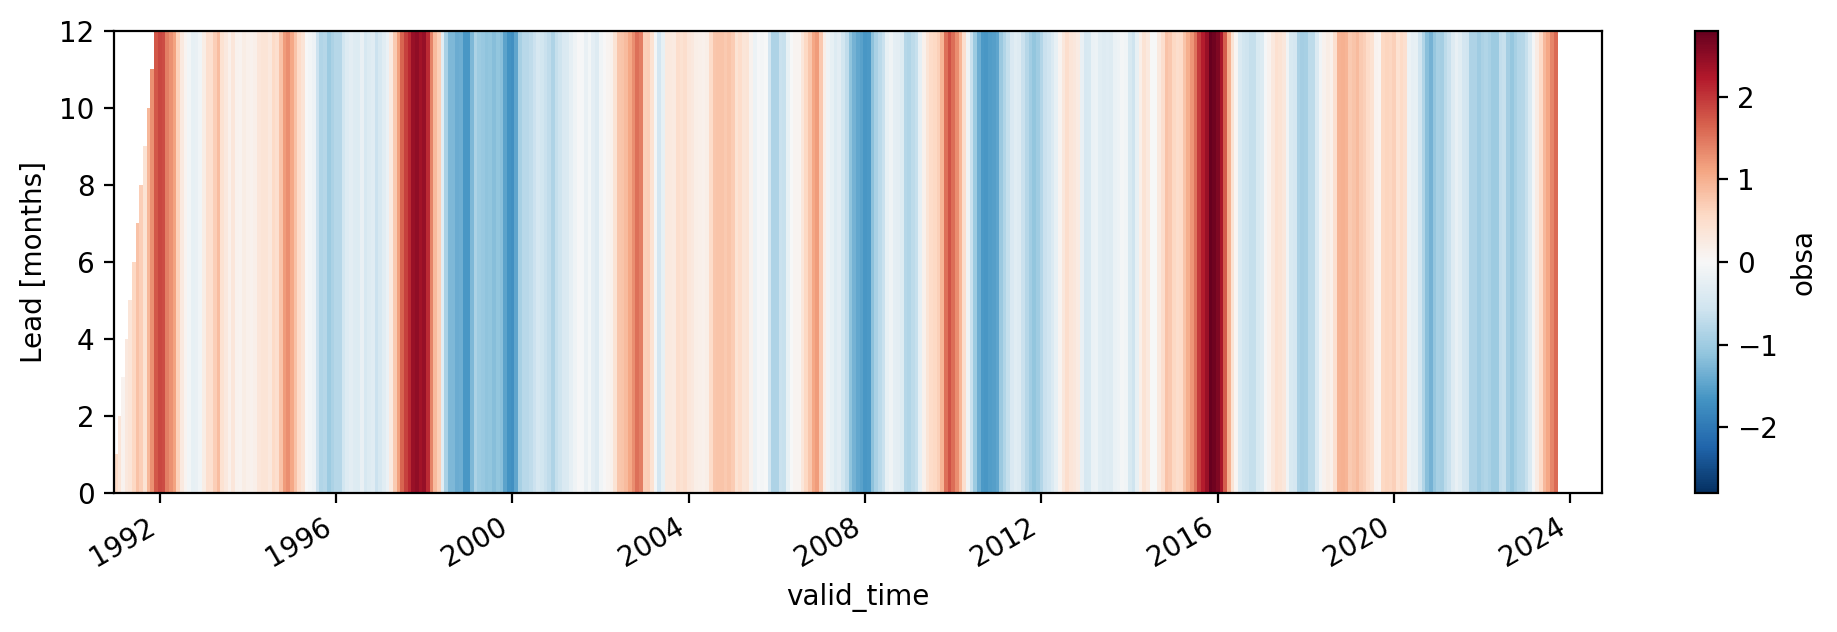

In [12]:
ds_TL.obsa.plot(figsize=(12, 3));